In [24]:
%matplotlib inline
import os
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import pyGadget
mpl.rc('figure', figsize=(16,12))
mpl.rc('font', size=20.)
mpl.rc('font', family='serif')
mpl.rc('text', usetex=True)

In [25]:
yr = 3600 * 24 * 365.25
gs = 500
s = 1
cool = plt.cm.Blues_r
warm = plt.cm.autumn

In [26]:
def freefall_time(ndensity, density=None):
    yr = 3600 * 24 * 365.25
    if not density:
        density = ndensity * 1.6726e-24
    return np.sqrt(3 / (32 * np.pi * 6.67e-8 * density))/yr

def connect_ids(snap, pids):
    # Find the snapshot indicies of the particles in the given array of pids, in same order.
    sort_idx = np.argsort(snap.gas.particleIDs)
    sorting = np.searchsorted(snap.gas.particleIDs, pids, sorter=sort_idx)
    return np.take(sort_idx, sorting)

def cold_dense_gas(snap, cooling_data, heating_data):
    yr = 3600 * 24 * 365.25
    mass = snap.gas.get_masses()
    temp = snap.gas.get_temperature()
    t_ff = snap.gas.get_freefall_time()
    tcool = cdata["tchem"]/yr
    theat = hdata["tchem"]/yr
    
    # cooling gas
    matchlist = connect_ids(snap, cdata["pid"])
    tff = np.take(t_ff, matchlist)
    m = np.take(mass, matchlist)
    cooling_coldgas = np.where(tcool < tff)[0]
    cold_mass = np.take(m, cooling_coldgas).sum()
    
    # heating gas
    matchlist = connect_ids(snap, hdata["pid"])
    tff = np.take(t_ff, matchlist)
    m = np.take(mass, matchlist)
    heating_coldgas = np.where(theat < tff)[0]
    cold_mass += np.take(m, heating_coldgas).sum()
    
    coldgas = np.hstack((cooling_coldgas, heating_coldgas))
    return cold_mass, coldgas

def cold_dense_gas2(snap, cooling_data, heating_data):
    mass = snap.gas.get_masses()
    ncool = cdata["n"]
    nheat = hdata["n"]
    tcool = cdata["tchem"]/yr
    theat = hdata["tchem"]/yr
    
    # cooling gas
    cooling_coldgas = np.where(tcool < freefall_time(ncool))[0]
    cold_mass = cooling_coldgas.size * mass.min()
    # heating gas
    #heating_coldgas = np.where(theat < freefall_time(nheat))[0]
    #cold_mass += heating_coldgas.size * mass.min()
    
    #coldgas = np.hstack((cooling_coldgas, heating_coldgas))
    return cold_mass, cooling_coldgas

In [27]:
simV = pyGadget.sim.Simulation('stampede/vanilla', track_sinks=True)
sim1 = pyGadget.sim.Simulation('stampede/XR_sfr_1e-3', track_sinks=True)
sim2 = pyGadget.sim.Simulation('stampede/XR_sfr_1e-2', track_sinks=True)
sim3 = pyGadget.sim.Simulation('stampede/XR_sfr_1e-1', track_sinks=True)

No sink specified: Selecting first sink to form...
Key set: nform = 1
Using sink ID 3103667
Found sinkfiles.  Loading sinkdata.
Key set: nform = 2
Using sink ID 3975878
No sink specified: Selecting first sink to form...
Key set: nform = 1
Using sink ID 3362134
Found sinkfiles.  Loading sinkdata.
Key set: nform = 2
Using sink ID 4394567
Key set: nform = 3
Using sink ID 4011741
No sink specified: Selecting first sink to form...
Key set: nform = 1
Using sink ID 3768236
Found sinkfiles.  Loading sinkdata.
Key set: nform = 2
Using sink ID 3755849
Key set: nform = 3
Using sink ID 3754749
Key set: nform = 4
Using sink ID 3975112
Key set: nform = 5
Using sink ID 4088092
Key set: nform = 6
Using sink ID 3719531
Key set: nform = 7
Using sink ID 4088845
Key set: nform = 8
Using sink ID 4407511
Key set: nform = 9
Using sink ID 4015446
Key set: nform = 10
Using sink ID 4958838
No sink specified: Selecting first sink to form...
Key set: nform = 1
Using sink ID 3962586
Found sinkfiles.  Loading sinkd

# At Sink Formation

In [28]:
snapV = simV.load_snapshot(355, "particleIDs", "t_ff")
snap1 = sim1.load_snapshot(269, "particleIDs", "t_ff")
snap2 = sim2.load_snapshot(201, "particleIDs", "t_ff")
snap3 = sim3.load_snapshot(200, "particleIDs", "t_ff")

V = np.load(os.getenv('HOME')+'/sim/chemistry/stampede/vanilla/cooltime_0355.npz')
J0 = np.load(os.getenv('HOME')+'/sim/chemistry/stampede/XR_sfr_1e-3/cooltime_0269.npz')
J10 = np.load(os.getenv('HOME')+'/sim/chemistry/stampede/XR_sfr_1e-2/cooltime_0201.npz')
J100 = np.load(os.getenv('HOME')+'/sim/chemistry/stampede/XR_sfr_1e-1/cooltime_0200.npz')

hV = np.load(os.getenv('HOME')+'/sim/chemistry/stampede/vanilla/heattime_0355.npz')
hJ0 = np.load(os.getenv('HOME')+'/sim/chemistry/stampede/XR_sfr_1e-3/heattime_0269.npz')
hJ10 = np.load(os.getenv('HOME')+'/sim/chemistry/stampede/XR_sfr_1e-2/heattime_0201.npz')
hJ100 = np.load(os.getenv('HOME')+'/sim/chemistry/stampede/XR_sfr_1e-1/heattime_0200.npz')

Turning on gas particle refinement.
There are 8000000 highest resolution particles.
Tracking sinks.
0 sinks found.
Loading data...
Turning on gas particle refinement.
There are 8000000 highest resolution particles.
Tracking sinks.
0 sinks found.
Loading data...
Turning on gas particle refinement.
There are 8000000 highest resolution particles.
Tracking sinks.
0 sinks found.
Loading data...
Turning on gas particle refinement.
There are 8000000 highest resolution particles.
Tracking sinks.
0 sinks found.
Loading data...


In [29]:
cold_mass_t0 = []
sink_mass_t0 = []
for snap,cdata,hdata in [(snapV, V, hV), (snap1, J0, hJ0), (snap2, J10, hJ10), (snap3, J100, hJ100)]:
    print '\n',snap.sim.name
    sunk_mass = 0
    for sink in snap.sinks:
        sunk_mass += sink.mass
    print "Sunk Mass:", sunk_mass
    sink_mass_t0.append(sunk_mass)
    
    n = cdata['n']
    t = cdata['tchem']/yr
    print 'cooling data: n.size=', n.size, 't.size=',t.size
    n = hdata['n']
    t = hdata['tchem']/yr
    print 'heating data: n.size=', n.size, 't.size=',t.size
    cold_mass,cold_gas = cold_dense_gas2(snap, cdata, hdata)
    print 'Cold Mass:', cold_mass, 'Ncold:', cold_gas.size
    cold_mass_t0.append(cold_mass)


stampede/vanilla
Sunk Mass: 0
cooling data: n.size= 7999754 t.size= 7999754
heating data: n.size= 246 t.size= 246
Cold Mass: 419.992228821 Ncold: 28434

stampede/XR_sfr_1e-3
Sunk Mass: 0
cooling data: n.size= 590002 t.size= 590002
heating data: n.size= 7409998 t.size= 7409998
Cold Mass: 586.399784912 Ncold: 39700

stampede/XR_sfr_1e-2
Sunk Mass: 0
cooling data: n.size= 454431 t.size= 454431
heating data: n.size= 7545569 t.size= 7545569
Cold Mass: 1558.02139326 Ncold: 105480

stampede/XR_sfr_1e-1
Sunk Mass: 0
cooling data: n.size= 228986 t.size= 228986
heating data: n.size= 7771014 t.size= 7771014
Cold Mass: 1647.59137552 Ncold: 111544


Cold Mass: 419.992228821 Ncold: 111544
cooling data: n.size= 7999754 t.size= 7999754
Cold Mass: 586.399784912 Ncold: 111544
cooling data: n.size= 590002 t.size= 590002
Cold Mass: 1558.02139326 Ncold: 111544
cooling data: n.size= 454431 t.size= 454431
Cold Mass: 1647.59137552 Ncold: 111544
cooling data: n.size= 228986 t.size= 228986


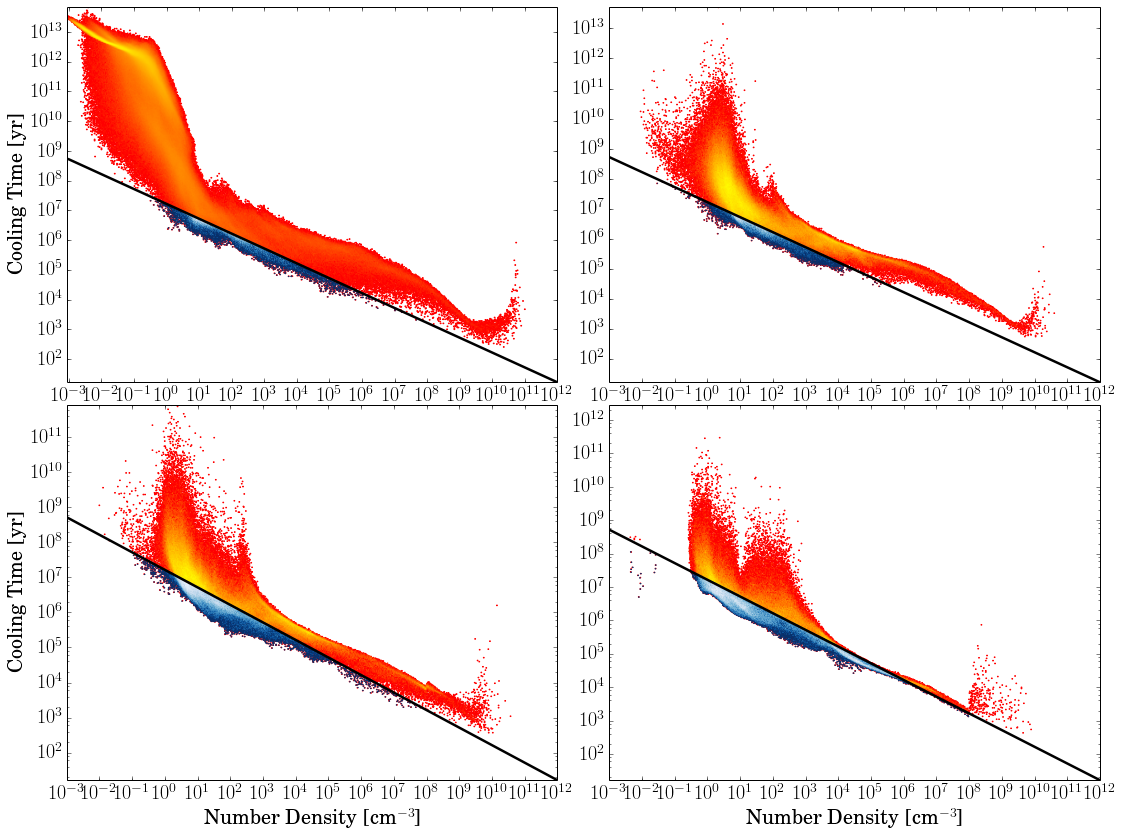

In [30]:
fig = plt.figure(2, figsize=(16,12))
ax0 = fig.add_subplot(221)
ax1 = fig.add_subplot(222)
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(224)

ndens = np.logspace(-3, 12, 100)
rho = 1.6726e-24 * ndens
tff = np.sqrt(3 / (32 * np.pi * 6.67e-8 * rho))

for snap,cdata,hdata,ax in [(snapV, V, hV,ax0), (snap1, J0, hJ0,ax1), (snap2, J10, hJ10,ax2), (snap3, J100, hJ100,ax3)]:
    cold_mass,coldgas = cold_dense_gas2(snap, cdata, hdata)
    print 'Cold Mass:', cold_mass, 'Ncold:', cold_gas.size
    n = cdata['n']
    t = cdata['tchem']/yr
    cn = n[coldgas]
    ct = t[coldgas]
    print 'cooling data: n.size=', n.size, 't.size=',t.size
    ax.hexbin(n, t, gridsize=gs, bins='log', xscale='log', yscale='log', mincnt=1, cmap=warm)
    ax.hexbin(cn, ct, gridsize=gs, bins='log', xscale='log', yscale='log', mincnt=1, cmap=cool)
    ax.plot(ndens,tff/yr, 'k', lw=2.5)

ax0.set_ylabel('Cooling Time [yr]')
ax2.set_ylabel('Cooling Time [yr]')
ax2.set_xlabel('Number Density [cm$^{-3}$]')
ax3.set_xlabel('Number Density [cm$^{-3}$]')


plt.tight_layout(w_pad=0.0,h_pad=0.0)
fig.savefig('figures/cdgm_t0.png', bbox_inches='tight')

# At Final Snapshot

In [31]:
snapV = simV.load_snapshot(1900, "particleIDs", "t_ff")
snap1 = sim1.load_snapshot(1794, "particleIDs", "t_ff")
snap2 = sim2.load_snapshot(1701, "particleIDs", "t_ff")
snap3 = sim3.load_snapshot(1700, "particleIDs", "t_ff")

V = np.load(os.getenv('HOME')+'/sim/chemistry/stampede/vanilla/cooltime_1900.npz')
J0 = np.load(os.getenv('HOME')+'/sim/chemistry/stampede/XR_sfr_1e-3/cooltime_1794.npz')
J10 = np.load(os.getenv('HOME')+'/sim/chemistry/stampede/XR_sfr_1e-2/cooltime_1701.npz')
J100 = np.load(os.getenv('HOME')+'/sim/chemistry/stampede/XR_sfr_1e-1/cooltime_1700.npz')

hV = np.load(os.getenv('HOME')+'/sim/chemistry/stampede/vanilla/heattime_1900.npz')
hJ0 = np.load(os.getenv('HOME')+'/sim/chemistry/stampede/XR_sfr_1e-3/heattime_1794.npz')
hJ10 = np.load(os.getenv('HOME')+'/sim/chemistry/stampede/XR_sfr_1e-2/heattime_1701.npz')
hJ100 = np.load(os.getenv('HOME')+'/sim/chemistry/stampede/XR_sfr_1e-1/heattime_1700.npz')

Turning on gas particle refinement.
There are 7997231 highest resolution particles.
Tracking sinks.
2 sinks found.
Loading data...
Turning on gas particle refinement.
There are 7998436 highest resolution particles.
Tracking sinks.
2 sinks found.
Loading data...
Turning on gas particle refinement.
There are 7995003 highest resolution particles.
Tracking sinks.
6 sinks found.
Loading data...
Turning on gas particle refinement.
There are 7999275 highest resolution particles.
Tracking sinks.
3 sinks found.
Loading data...


In [32]:
cold_mass_final = []
sink_mass_final = []
for snap,cdata,hdata in [(snapV, V, hV), (snap1, J0, hJ0), (snap2, J10, hJ10), (snap3, J100, hJ100)]:
    print '\n',snap.sim.name
    sunk_mass = 0
    for sink in snap.sinks:
        sunk_mass += sink.mass
    print "Sunk Mass:", sunk_mass
    sink_mass_final.append(sunk_mass)
    
    n = cdata['n']
    t = cdata['tchem']/yr
    print 'cooling data: n.size=', n.size, 't.size=',t.size
    n = hdata['n']
    t = hdata['tchem']/yr
    print 'heating data: n.size=', n.size, 't.size=',t.size
    cold_mass,cold_gas = cold_dense_gas2(snap, cdata, hdata)
    print 'Cold Mass:', cold_mass, 'Ncold:', cold_gas.size
    cold_mass_final.append(cold_mass)


stampede/vanilla
Sunk Mass: 40.9298187403
cooling data: n.size= 7997221 t.size= 7997221
heating data: n.size= 8 t.size= 8
Cold Mass: 428.190009189 Ncold: 28989

stampede/XR_sfr_1e-3
Sunk Mass: 23.1310343368
cooling data: n.size= 587589 t.size= 587589
heating data: n.size= 7410845 t.size= 7410845
Cold Mass: 595.454270255 Ncold: 40313

stampede/XR_sfr_1e-2
Sunk Mass: 73.8981895192
cooling data: n.size= 449481 t.size= 449481
heating data: n.size= 7545516 t.size= 7545516
Cold Mass: 1605.47989475 Ncold: 108693

stampede/XR_sfr_1e-1
Sunk Mass: 10.7531245193
cooling data: n.size= 229062 t.size= 229062
heating data: n.size= 7770210 t.size= 7770210
Cold Mass: 1663.64720842 Ncold: 112631


Cold Mass: 428.190009189 Ncold: 112631
cooling data: n.size= 7997221 t.size= 7997221
Cold Mass: 595.454270255 Ncold: 112631
cooling data: n.size= 587589 t.size= 587589
Cold Mass: 1605.47989475 Ncold: 112631
cooling data: n.size= 449481 t.size= 449481
Cold Mass: 1663.64720842 Ncold: 112631
cooling data: n.size= 229062 t.size= 229062


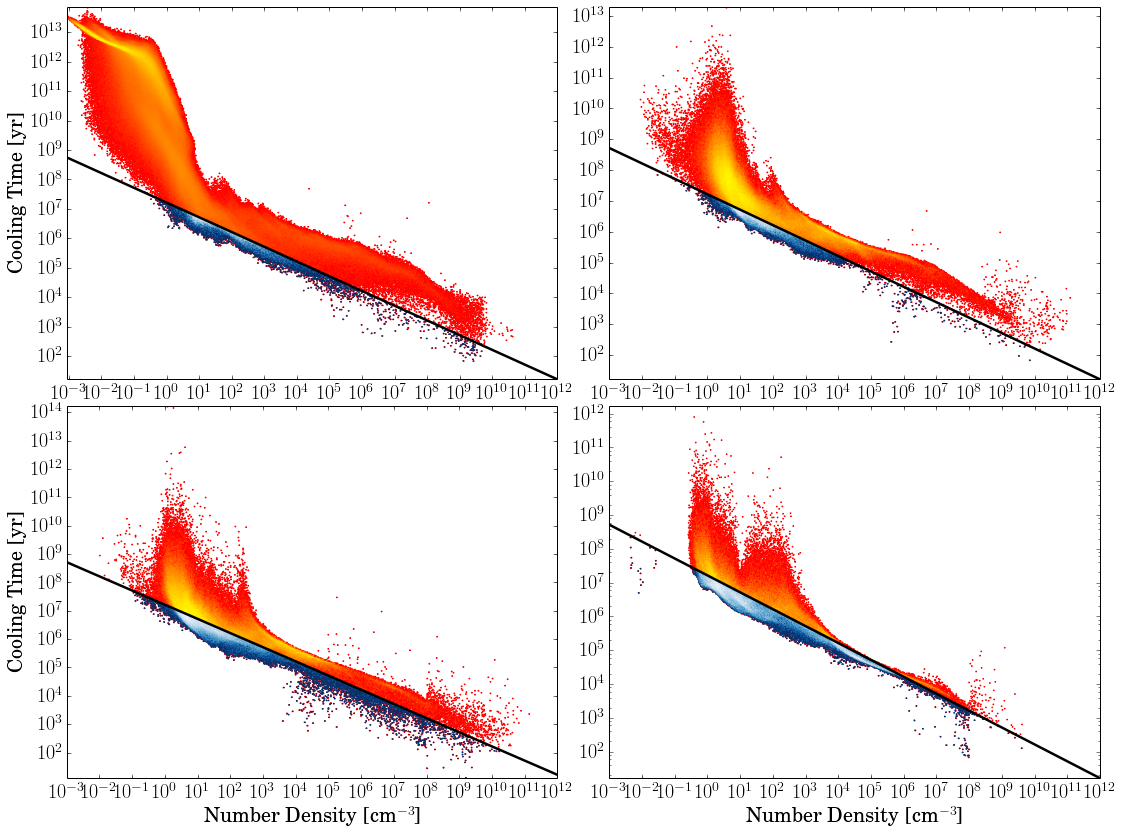

In [33]:
fig = plt.figure(2, figsize=(16,12))
ax0 = fig.add_subplot(221)
ax1 = fig.add_subplot(222)
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(224)

ndens = np.logspace(-3, 12, 100)
rho = 1.6726e-24 * ndens
tff = np.sqrt(3 / (32 * np.pi * 6.67e-8 * rho))

for snap,cdata,hdata,ax in [(snapV, V, hV,ax0), (snap1, J0, hJ0,ax1), (snap2, J10, hJ10,ax2), (snap3, J100, hJ100,ax3)]:
    cold_mass,coldgas = cold_dense_gas2(snap, cdata, hdata)
    print 'Cold Mass:', cold_mass, 'Ncold:', cold_gas.size
    n = cdata['n']
    t = cdata['tchem']/yr
    cn = n[coldgas]
    ct = t[coldgas]
    print 'cooling data: n.size=', n.size, 't.size=',t.size
    ax.hexbin(n, t, gridsize=gs, bins='log', xscale='log', yscale='log', mincnt=1, cmap=warm)
    ax.hexbin(cn, ct, gridsize=gs, bins='log', xscale='log', yscale='log', mincnt=1, cmap=cool)
    ax.plot(ndens,tff/yr, 'k', lw=2.5)

ax0.set_ylabel('Cooling Time [yr]')
ax2.set_ylabel('Cooling Time [yr]')
ax2.set_xlabel('Number Density [cm$^{-3}$]')
ax3.set_xlabel('Number Density [cm$^{-3}$]')


plt.tight_layout(w_pad=0.0,h_pad=0.0)
fig.savefig('figures/cdgm_final.png', bbox_inches='tight')

# At Same Cosmic Time

In [34]:
snapV = simV.load_snapshot(100, "particleIDs", "t_ff")
snap1 = sim1.load_snapshot(102, "particleIDs", "t_ff")
snap2 = sim2.load_snapshot(202, "particleIDs", "t_ff")
snap3 = sim3.load_snapshot(135, "particleIDs", "t_ff")

V = np.load(os.getenv('HOME')+'/sim/chemistry/stampede/vanilla/cooltime_0100.npz')
J0 = np.load(os.getenv('HOME')+'/sim/chemistry/stampede/XR_sfr_1e-3/cooltime_0102.npz')
J10 = np.load(os.getenv('HOME')+'/sim/chemistry/stampede/XR_sfr_1e-2/cooltime_0202.npz')
J100 = np.load(os.getenv('HOME')+'/sim/chemistry/stampede/XR_sfr_1e-1/cooltime_0135.npz')

hV = np.load(os.getenv('HOME')+'/sim/chemistry/stampede/vanilla/heattime_0100.npz')
hJ0 = np.load(os.getenv('HOME')+'/sim/chemistry/stampede/XR_sfr_1e-3/heattime_0102.npz')
hJ10 = np.load(os.getenv('HOME')+'/sim/chemistry/stampede/XR_sfr_1e-2/heattime_0202.npz')
hJ100 = np.load(os.getenv('HOME')+'/sim/chemistry/stampede/XR_sfr_1e-1/heattime_0135.npz')

Turning on gas particle refinement.
There are 8000000 highest resolution particles.
Tracking sinks.
0 sinks found.
Loading data...
Turning on gas particle refinement.
There are 8000000 highest resolution particles.
Tracking sinks.
0 sinks found.
Loading data...
Turning on gas particle refinement.
There are 7999968 highest resolution particles.
Tracking sinks.
1 sinks found.
Loading data...
Turning on gas particle refinement.
There are 8000000 highest resolution particles.
Tracking sinks.
0 sinks found.
Loading data...


In [35]:
cold_mass_z26 = []
sink_mass_z26 = []
for snap,cdata,hdata in [(snapV, V, hV), (snap1, J0, hJ0), (snap2, J10, hJ10), (snap3, J100, hJ100)]:
    print '\n',snap.sim.name
    sunk_mass = 0
    for sink in snap.sinks:
        sunk_mass += sink.mass
    print "Sunk Mass:", sunk_mass
    sink_mass_tot.append(sunk_mass)
    
    n = cdata['n']
    t = cdata['tchem']/yr
    print 'cooling data: n.size=', n.size, 't.size=',t.size
    n = hdata['n']
    t = hdata['tchem']/yr
    print 'heating data: n.size=', n.size, 't.size=',t.size
    cold_mass,cold_gas = cold_dense_gas2(snap, cdata, hdata)
    print 'Cold Mass:', cold_mass, 'Ncold:', cold_gas.size
    cold_mass_z26.append(cold_mass)


stampede/vanilla
Sunk Mass: 0
cooling data: n.size= 8000000 t.size= 8000000
heating data: n.size= 0 t.size= 0
Cold Mass: 137.279586926 Ncold: 9294

stampede/XR_sfr_1e-3
Sunk Mass: 0
cooling data: n.size= 528899 t.size= 528899
heating data: n.size= 7471101 t.size= 7471101
Cold Mass: 321.29390734 Ncold: 21752

stampede/XR_sfr_1e-2
Sunk Mass: 0.487435589473
cooling data: n.size= 697669 t.size= 697669
heating data: n.size= 7302298 t.size= 7302298
Cold Mass: 2179.79718535 Ncold: 147575

stampede/XR_sfr_1e-1
Sunk Mass: 0
cooling data: n.size= 6364891 t.size= 6364891
heating data: n.size= 1635109 t.size= 1635109
Cold Mass: 31336.2739468 Ncold: 2121505


Cold Mass: 137.279586926 Ncold: 9294
cooling data: n.size= 8000000 t.size= 8000000
Cold Mass: 321.29390734 Ncold: 21752
cooling data: n.size= 528899 t.size= 528899
Cold Mass: 2179.79718535 Ncold: 147575
cooling data: n.size= 697669 t.size= 697669
Cold Mass: 31336.2739468 Ncold: 2121505
cooling data: n.size= 6364891 t.size= 6364891


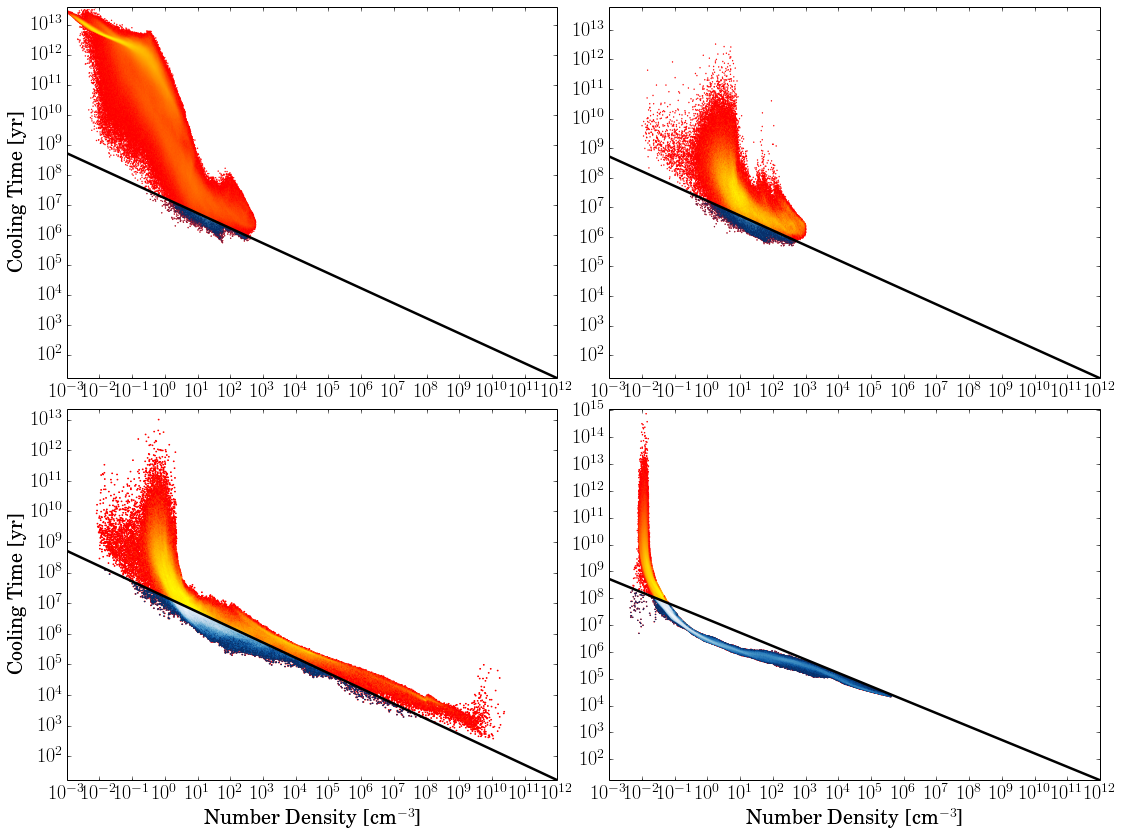

In [36]:
fig = plt.figure(2, figsize=(16,12))
ax0 = fig.add_subplot(221)
ax1 = fig.add_subplot(222)
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(224)

ndens = np.logspace(-3, 12, 100)
rho = 1.6726e-24 * ndens
tff = np.sqrt(3 / (32 * np.pi * 6.67e-8 * rho))

for snap,cdata,hdata,ax in [(snapV, V, hV,ax0), (snap1, J0, hJ0,ax1), (snap2, J10, hJ10,ax2), (snap3, J100, hJ100,ax3)]:
    cold_mass,coldgas = cold_dense_gas2(snap, cdata, hdata)
    print 'Cold Mass:', cold_mass, 'Ncold:', coldgas.size
    n = cdata['n']
    t = cdata['tchem']/yr
    cn = n[coldgas]
    ct = t[coldgas]
    print 'cooling data: n.size=', n.size, 't.size=',t.size
    ax.hexbin(n, t, gridsize=gs, bins='log', xscale='log', yscale='log', mincnt=1, cmap=warm)
    ax.hexbin(cn, ct, gridsize=gs, bins='log', xscale='log', yscale='log', mincnt=1, cmap=cool)
    ax.plot(ndens,tff/yr, 'k', lw=2.5)

ax0.set_ylabel('Cooling Time [yr]')
ax2.set_ylabel('Cooling Time [yr]')
ax2.set_xlabel('Number Density [cm$^{-3}$]')
ax3.set_xlabel('Number Density [cm$^{-3}$]')


plt.tight_layout(w_pad=0.0,h_pad=0.0)
fig.savefig('figures/cdgm_z26.png', bbox_inches='tight')

# vs Disk Mass / Sink Mass

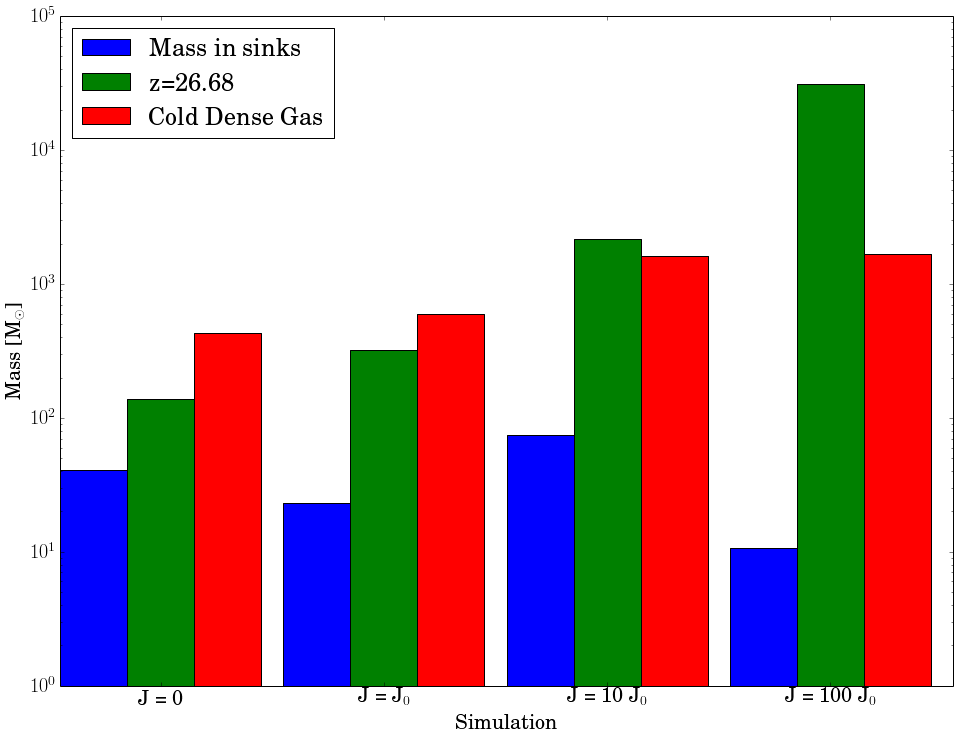

In [39]:
n_sims = 4
index = np.arange(n_sims)
disk_mass = np.array([52, 0,0,0])
bar_width = 0.3
plt.bar(index, sink_mass_final, bar_width, log=True, color='b', label="Mass in sinks")
plt.bar(index + bar_width, cold_mass_z26, bar_width, log=True, color='g', label="z=26.68")
plt.bar(index + bar_width*2, cold_mass_final, bar_width, log=True, color='r', label="Cold Dense Gas")
plt.ylim(1,1e5)
plt.xlabel("Simulation")
plt.ylabel("Mass [M$_{\odot}$]")
plt.xticks(index + 1.5*bar_width, ('J = 0', 'J = J$_0$', 'J = 10 J$_0$', 'J = 100 J$_0$'))
plt.legend(loc=2)
plt.savefig('figures/cdgm-sinks.png', bbox_inches='tight')